# Introduction

Voici la consigne de cette étude:

> locationmaison.fr est une application qui révolutionne le tourisme. Elle propose à des résidents de temporairement recevoir des touristes pour leur faire découvrir la vie locale.
>
> Votre cabinet de consultant vient justement de décrocher un contrat avec cette startup ! Elle a besoin de votre aide pour identifier les quartiers de Paris les plus prometteurs à la location. Elle souhaite notamment déterminer quels sont les critères (arrondissement, prix, nombre de lits) importants, afin de construire une offre de location pertinente.
>
> Pour donner des pistes à votre client, nous avons collecté des informations disponibles sur une application concurrente, qui est présente sur le marché parisien depuis plusieurs années. Bien que vous n'ayez pas une offre commerciale tout à fait similaire, c'est un bon point de départ pour comprendre les habitudes des touristes de la région, alors à vous de répondre aux questions suivantes :
> * Quel est le nombre optimal de chambres/lits/salles de bain ?
> * Quelle est la fourchette de prix optimale ?
>
> Dans un second temps un partenaire de l’entreprise cherche à prédire à l’aide de la Base de données présente, les prix de nouveaux logements.
L’entreprise souhaiterais recevoir le travail sous 1 jour et la solution devra être réalisée dans un Jupyter Notebook.

Dans un fichier de plus de 40000 lignes, sont données les caractéristiques suivantes:
- Type de propriété
- Quartier
- Arrondissement
- Capacité d’accueil
- Nombre de salle de bain
- Nombre de chambres
- Nombres de lits
- Prix
- Nombre de commentaires
- Note moyenne
- Nombre de mois d’activités

La deuxième partie de ce notebook traite de la question: quel est le logement optimal et à quel prix en fonction du quartier ? Il semblerait que **les propriétés les plus interessantes sont les petits logements** (une chambre, un lit ou une salle de bain), car ils sont nombreux et leur prix cumulé dépasse largement celui des plus grands logements. Leur prix se situe en moyenne entre 70 et 80€. Les trois quartiers de la Butte Montmartre, de Paupincourt et de Vaugirard sont particulièrement intéressants, car proposant le plus de petits logements en location touristique. Comme le nombre de logement disponible à la location est essentielle pour estimer l'importance d'une catégorie de logement. J'ai regardé la croissance de l'offre de location en fonction du quartier et de la taille des logements. Les petits logements ont une croissance légèrement plus importante que les grands et les quartiers les plus en croissance sont la Butte Montmartre, les Gobelins et Ménilmontant. Ainsi le **quartier de la Butte Montmartre est le plus interessant**, car ayant le plus de logements en location et avec la plus grande croissance.

La troisième partie propose deux modèles pour tenter de prédire le prix des logements : la **régression linéaire** et les **random forests**. Malheureusement leurs **performances ne sont pas satisfaisantes**. En effet, ils ont une erreur moyenne qui représente la moitié du prix moyen. Les raisons sont multiples. Par manque de temps, je n'ai pas pu explorer plus de modèles, ni plus de configurations de paramètres pour les random forests. Toutefois, la distribution des données rend toutes prédictions difficiles. Les petits logements (une chambre, un lit, une capacité d'acceuil de 2) représentent plus de la moitié des logements. Or ces trois critères de taille sont les caractétiristiques les plus significatives, voir les seules importantes dans les données à disposition. Le prix varie au sein de la grande catégorie de petits logements. Ainsi il faudrait des caractéristiques supplémentaires pour aider à prédire ces variations: localisation plus précise, taux d'activité, note de l'état général et des services associés, surface du logement, équipements...


## Chargement des librairies et données

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pylab as pb
import itertools

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import unidecode


In [3]:
from Tools.CurveClass import CurveClass
from Tools import Models
from Tools.Models import *

In [4]:
df_row = pd.read_csv('data/location.csv')
df_row

,type_propriete,quartier,arrondissement,capacite_accueil,salle_de_bain,chambres,lits,prix,nb_commentaires,note_moyenne,nb_mois_en_activite
0,Complète,Observatoire,75014,2,1.0,NaN,1.0,60.0,9,100.0,34.0
1,Complète,Hôtel-de-Ville,75004,4,1.0,2.0,2.0,90.0,272,94.0,119.0
2,Complète,Opéra,75009,2,1.0,1.0,1.0,130.0,6,96.0,64.0
3,Complète,Popincourt,75011,2,1.0,1.0,1.0,75.0,26,98.0,91.0
4,Chambre privée,Entrepôt,75010,6,1.0,1.0,3.0,170.0,149,92.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...
41433,Complète,Bourse,75002,4,2.0,2.0,2.0,101.0,0,NaN,NaN
41434,Complète,Bourse,75002,4,2.0,2.0,2.0,101.0,0,NaN,NaN
41435,Complète,Bourse,75002,4,2.0,2.0,2.0,118.0,0,NaN,NaN
41436,Complète,Opéra,75009,4,1.0,2.0,2.0,192.0,0,NaN,NaN


In [5]:
df_row.describe()

,arrondissement,capacite_accueil,salle_de_bain,chambres,lits,prix,nb_commentaires,note_moyenne,nb_mois_en_activite
count,41438.000000,41438.000000,41438.000000,33214.000000,41293.000000,41438.000000,41438.000000,32413.000000,33167.000000
mean,75012.288962,3.096843,1.121531,1.387246,1.691183,108.505309,20.549471,93.605004,20.788977
std,5.515351,1.609637,0.374932,0.714914,1.103502,171.468815,42.118658,8.079865,22.775596
min,75001.000000,1.000000,0.000000,1.000000,0.000000,8.000000,0.000000,20.000000,0.000000
25%,75009.000000,2.000000,1.000000,1.000000,1.000000,59.000000,1.000000,91.000000,2.000000
50%,75012.000000,2.000000,1.000000,1.000000,1.000000,80.000000,6.000000,96.000000,13.000000
75%,75017.000000,4.000000,1.000000,2.000000,2.000000,118.000000,21.000000,100.000000,32.000000
max,75020.000000,16.000000,6.000000,9.000000,16.000000,9280.000000,796.000000,100.000000,134.000000


# Première analyse: quel est le logement optimal et à quel prix en fonction du quartier ?

## Introduction 

Pour répondre pleinement à la question de quelle offre de location est pertinente, il me semble qu'il manque une donnée essentielle: le taux d'activité d'un logement. En effet, le temps moyen de location (ou à l'inverse le temps moyen de vacation) est une indication directe de l'attractivité d'un logement et donc serait décisif pour comprendre quelles caractéristiques sont importantes.

Je pourrais utiliser le nombre de commentaires par mois d'activité comme proxy pour estimer le taux d'activité. Mais je vois deux grandes objections. La première est qualitative. L'absence de commentaire ne veut pas dire un taux nul d'activité. En effet, peu d'utilisateurs laissent des commentaires. De plus, les personnes ayant l'habitude de laisser un commentaire représente une sous population spécifique. Baser une étude sur leur comportement aurait une forte probabilité de présenter un biais. La seconde objection est quantitative. La grande majorité des logements ont aucun commentaire et un nombre de mois d'activité indiqué à zero. Cette repartition ne permet pas une bonne discrimination entre les critéres pour mesurer leur importance.

Je propose donc une étude qui mesure la pertinence d'un logement par son prix. Autrement dit je suppose qu'un logement a un taux d'activité constant quelque soit ces caractéristiques. Ainsi le rendement d'une catégorie de logements s'obtient par la somme des prix des logements constituant cette catégorie.

Ce choix est cohérent avec la deuxième partie de l'étude qui va chercher à prédire le prix d'un logement en fonction de ses caractéristiques.

**Remarque**: Mon analyse des caractéristiques dans la partie en Annexe *Analyses et commentaires de quaque caractéristique* ne révèle pas de données abhérantes flagrantes ou trop nombreuses. Je fais donc cette première partie de l'étude en utilisant directement les données brutes.

## Tout Paris

Je regarde d'abord les résultats dans tout Paris.

Il n'est pas étonnant de constater que les logements les plus grands (plus de chambres, lits ou salles de bains) sont les plus chers. De plus, les moins chers sont les plus nombreux.

La question est donc de savoir s'il est plus rentable de louer des logements plus petits et moins chers, mais plus nombreux; ou de se concentrer sur les logements plus rares, mais plus onéreux.

La réponse est que **le nombre des petits logements (une chambre, un lit ou une salle de bain) compense largement leur petit loyer et les rend plus rentables que les grands logements**.

Par conséquent, la **fourchette de prix optimale** correspond à celle des petits logements (les plus nombreux) et est donc **entre 70 et 100€**.

Les trois figures suivantes représentent le nombre de logements, le prix moyen et le prix total en fonction du nombre de chambres, lits et salles de bain. Le quatrième graphe représente le prix total (prix\*nombre de logements) en fonction du prix moyen.

### Graphes

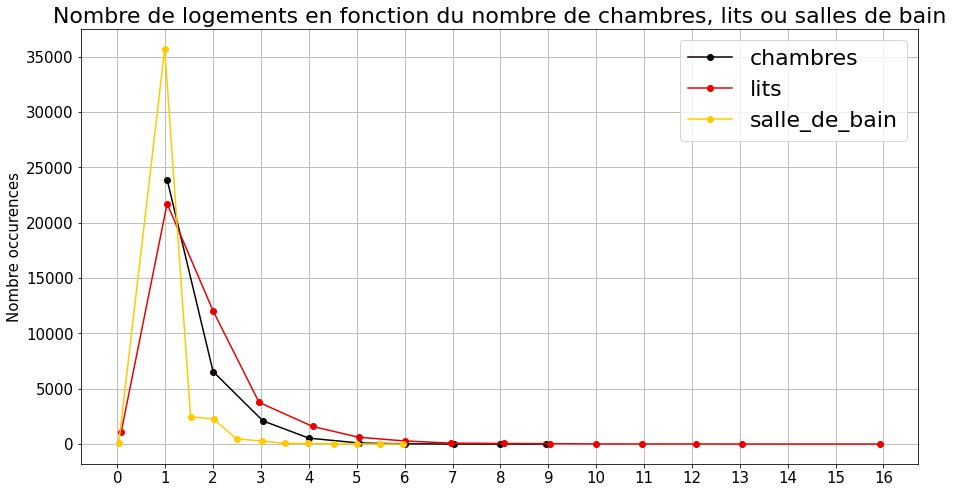

In [6]:
curve = CurveClass(3)
for name in ['chambres', 'lits', 'salle_de_bain']:
    vals = list(df_row[name].dropna())

    curve.hist(vals, bins=100, ylabel='Nombre occurences', marker='o', label=name)
    curve.ax.set_xticks(range(0, 17))
    curve.ax.grid()
    curve.title("Nombre de logements en fonction du nombre de chambres, lits ou salles de bain")
curve.legend()

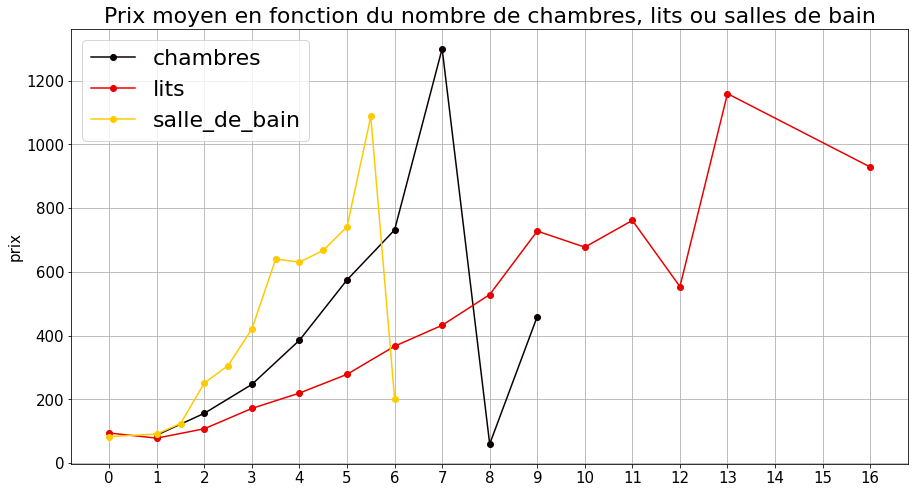

In [7]:
curve = CurveClass(3)
for name in ['chambres', 'lits', 'salle_de_bain']:
    df_temp = df_row[[name, 'prix']]
    df_temp = df_temp.groupby(name).mean()

    curve.plot(df_temp.index, df_temp['prix'], ylabel='prix', marker='o', label=name)
    curve.ax.set_xticks(range(0, 17))
    curve.ax.grid()
    curve.title("Prix moyen en fonction du nombre de chambres, lits ou salles de bain")
curve.legend()

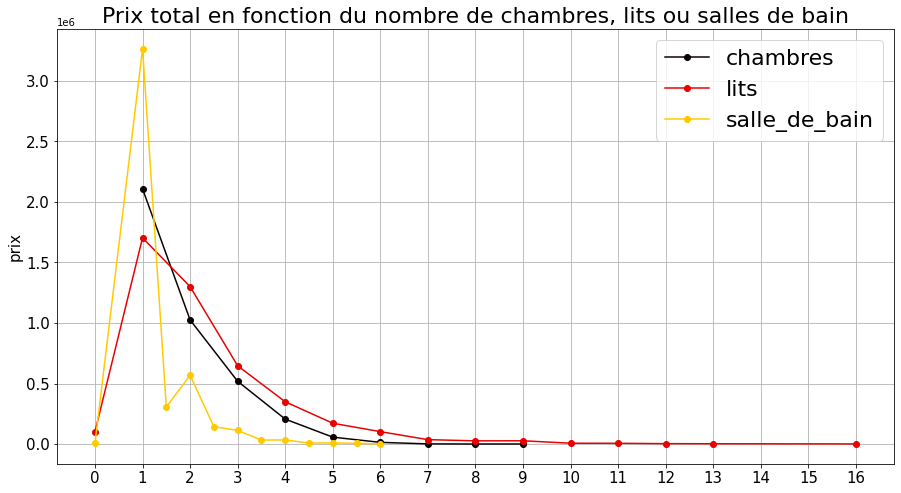

In [8]:
curve = CurveClass(3)
for name in ['chambres', 'lits', 'salle_de_bain']:
    df_temp = df_row[[name, 'prix']]
    df_temp = df_temp.groupby(name).sum()

    curve.plot(df_temp.index, df_temp['prix'], ylabel='prix', marker='o', label=name)
    curve.ax.set_xticks(range(0, 17))
    curve.ax.grid()
    curve.title("Prix total en fonction du nombre de chambres, lits ou salles de bain")
curve.legend()

Les logements les plus loués sont ceux avec un loyer entre 70 et 80 €



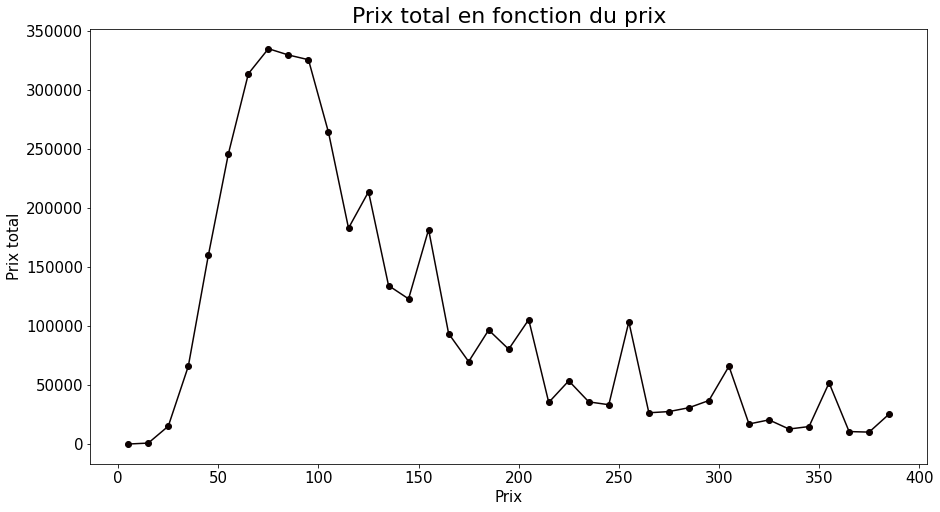

In [9]:
curve = CurveClass()

dx = 10
bins = np.arange(0, 400, dx)
y, x =  np.histogram(df_row['prix'], bins=bins)

x = (x[1:]+x[:-1])/2.
y = x*y

curve.plot(x, y, xlabel='Prix', ylabel='Prix total', marker='o')
curve.title('Prix total en fonction du prix')

opti = pd.DataFrame(list(zip(x, y)), columns=['x', 'y']).sort_values('y').iloc[-1, 0]

print(
    'Les logements les plus loués sont ceux avec un loyer entre %i et %i €' 
    % (float(opti)-dx/2, float(opti)+dx/2))
print()

### Chiffres détaillés

Quel est le nombre optimal de:
* **chambres** ? Le loyer le plus haut est de 1300€ pour un logement de 7 chambres, mais la propriété est unique. En revanche, les logements d'**une chambre** sont plus rentables, car rapportent **2 107 939€** pour un loyer moyen de 88€.

* **lits** ? Les meilleurs loyers sont ceux des logements à 13 lits avec une moyenne de 1159€ et un chiffre d'affaires de 2318€. Mais les logements d'**un lit** rapportent **1 703 518€** pour un loyer moyen de 78€.

* **salles de bain** ? Les logements de 5 salles de bain se louent en moyenne à 1087€ et rapportent 6525, alors que les logements à **un salle de bain** rapportent **3 265 969€** pour un loyer moyen de 91€.

In [10]:
name_to_predict = 'prix'
for focus_feature in ['chambres', 'lits', 'salle_de_bain']:
    
    # calcul de la moyenne des prix par nombre de chambre, lits ou salle de bain
    df_optimal = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).mean()
    
    # calcul du nombre de logements par nombre de chambre, lits ou salle de bain
    df_temp = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).count().rename(columns={'prix': 'compte'})
    df_optimal = df_optimal.merge(df_temp, left_index=True, right_index=True)
    
    
    # calcul du prix total des logements par nombre de chambre, lits ou salle de bain
    df_temp = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).sum().rename(columns={'prix': 'prix_total'})
    df_optimal = df_optimal.merge(df_temp, left_index=True, right_index=True)
    
    # obtention du prix moyen maximum et du prix total maximum
    opti = df_optimal.sort_values('prix').iloc[-1]
    opti_total = df_optimal.sort_values('prix_total').iloc[-1]
    
    # Affichage des résultats
    print(
        'Les logements à %i %s sont ceux avec le plus haut loyer\n (%i€ en moyenne) et rapportent au total %i' 
        % (float(opti.name), focus_feature, opti['prix'], opti['prix_total']))
    print(
        "Les logements à %i %s sont ceux qui rapportent le plus d'argent\n (total: %i€, loyer moyen: %i€, nombre: %i)"
        % (float(opti_total.name), focus_feature, opti_total['prix_total'], opti_total['prix'], opti_total['compte']))
    print()
    print()
        
    

Les logements à 7 chambres sont ceux avec le plus haut loyer
 (1300€ en moyenne) et rapportent au total 1300
Les logements à 1 chambres sont ceux qui rapportent le plus d'argent
 (total: 2107939€, loyer moyen: 88€, nombre: 23908)


Les logements à 13 lits sont ceux avec le plus haut loyer
 (1159€ en moyenne) et rapportent au total 2318
Les logements à 1 lits sont ceux qui rapportent le plus d'argent
 (total: 1703518€, loyer moyen: 78€, nombre: 21727)


Les logements à 5 salle_de_bain sont ceux avec le plus haut loyer
 (1087€ en moyenne) et rapportent au total 6525
Les logements à 1 salle_de_bain sont ceux qui rapportent le plus d'argent
 (total: 3265969€, loyer moyen: 91€, nombre: 35735)




## Par arrondissement

### Introduction

Ici je me demande quel arrondissement est le plus intéressant, mais aussi quel type de logements est le plus interessant en fonction des quartiers.

La proportion petits/grands logements ainsi que le loyer moyen varie fortement en fonction du quartier (voir les deux figures suivantes). Entre les quartiers Butte-Montmartre et Elysée, le loyer varie d'un facteur 2,5 et la porportion de grands logements double.

Les résultats démontrés pour le tout Paris pourraient donc n'être plus vrais dans certains quartiers. Par exemple, les grands et onéreux appartements haussmaniens du 6ème arrondissements pourraient devenir plus interessants que les studios moins nombreux dans cette zone. Par ailleurs, les tours du 13ème et du 19ème comporte plus de logements familiaux que de studios. Ces faits pourraient contre balancer le poids des petits logements. Toutefois ces réflexions sont surement plus vrais pour des locations de longues durées et moins pour les locations touristiques. 

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_28253/1364598681.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');


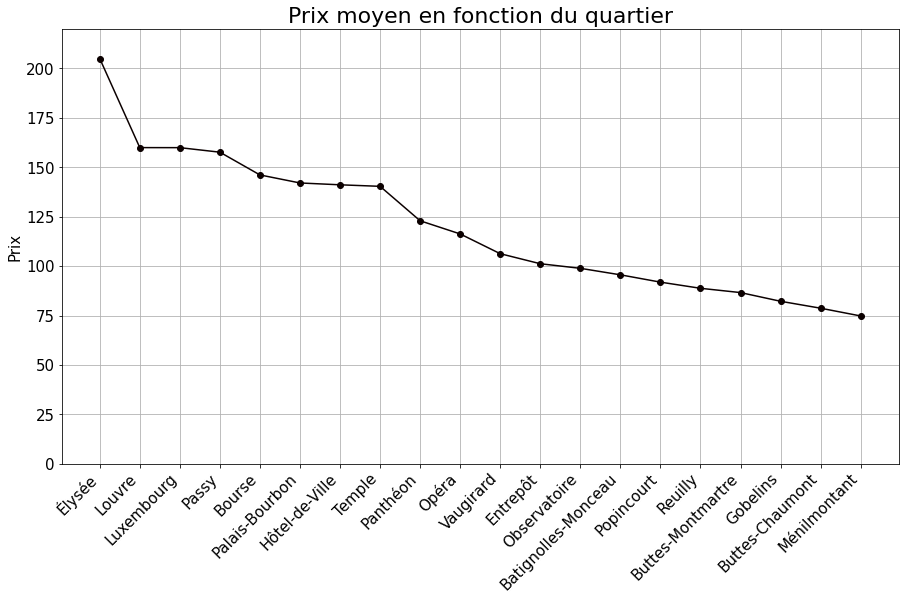

In [11]:
df_temp = df_row.copy()
df_temp = df_temp.groupby('quartier')['prix'].mean()
df_temp = df_temp.sort_values(ascending=False)

curve = CurveClass()
curve.plot(df_temp.index, df_temp, ylabel='Prix', marker='o')
curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');
curve.ax.grid()
curve.title("Prix moyen en fonction du quartier");
curve.ax.set_ylim(0, 220);

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_28253/1281593810.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');


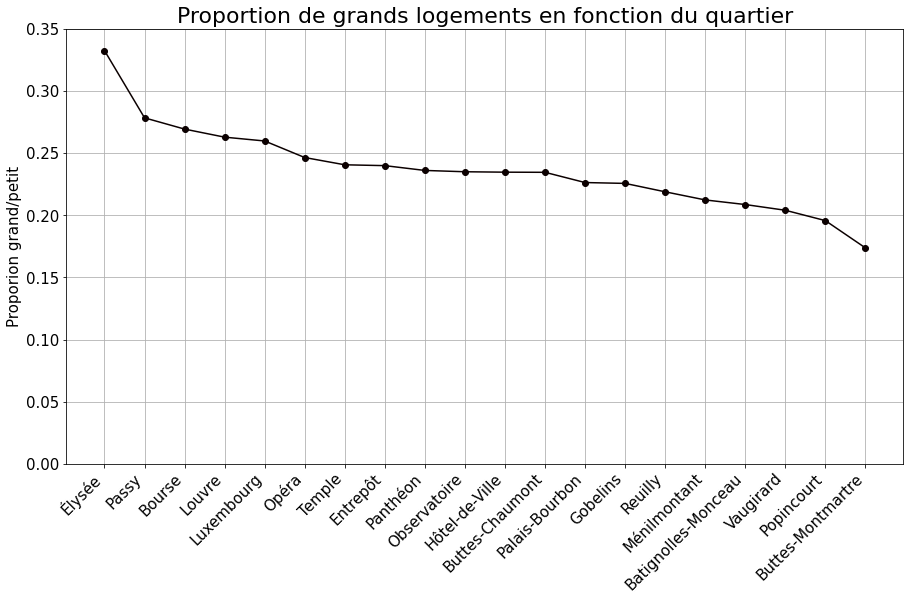

In [12]:
df_temp = df_row.copy()
df_temp['grand'] = (df_temp['chambres']>1).astype(int)
df_temp = df_temp.groupby(['grand', 'quartier']).count()['prix']
df_temp = df_temp.unstack('grand')
df_temp['prop_grand/petit'] = df_temp[1]/(df_temp[0]+df_temp[1])
df_temp = df_temp.sort_values('prop_grand/petit', ascending=False)

curve = CurveClass()
curve.plot(df_temp.index, df_temp['prop_grand/petit'], ylabel='Proporion grand/petit', marker='o')
curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');
curve.ax.grid()
curve.title("Proportion de grands logements en fonction du quartier")

curve.ax.set_ylim(0, .35);

### Tous logements confondus

Je propose un premier résultat sans distinguer les différents types de logements. Le **quartier le plus cher** est l'**Elysée** avec un loyer moyen de 205€ pour 908 logements et un rendement total de **186 163€**. Mais le **quartier le plus rentable** et avec le plus de logements est la **Butte Montmartre** avec 5029 logements, un loyer moyen de 86€ et  un rendement de **435 669€**.

Tous logements confondus, c'est encore le nombre de logements qui décide du quartier le plus rentable (voir la figure suivante). En effet, la Butte Montmartre est le quartier avec le plus de locations tandis que l'Elysée est celui avec le moins de logements après le Louvre.

In [13]:
name_to_predict = 'prix'
for focus_feature in ['quartier']:
    df_optimal = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).mean()
    
    df_temp = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).count().rename(columns={'prix': 'compte'})
    df_optimal = df_optimal.merge(df_temp, left_index=True, right_index=True)
    
    
    df_temp = df_row[[focus_feature, name_to_predict]].groupby(focus_feature).sum().rename(columns={'prix': 'prix_total'})
    df_optimal = df_optimal.merge(df_temp, left_index=True, right_index=True)
    
    # df_optimal = df_optimal[df_optimal['compte'] > 100]
    
    opti = df_optimal.sort_values('prix').iloc[-1]
    opti_total = df_optimal.sort_values('prix_total').iloc[-1]
    opti_compte = df_optimal.sort_values('compte').iloc[-1]
    
    print(
        'Les logements dans le %s sont ceux avec le plus haut loyer\n (%i€ en moyenne, %i€ au total, nombre logements: %i)' 
        % (opti.name, opti['prix'], opti['prix_total'], opti['compte']))
    print()
    print(
        "Les logements dans le %s sont ceux qui rapportent le plus d'argent\n (total: %i€, loyer moyen: %i€, nombre: %i)"
        % (opti_total.name, opti_total['prix_total'], opti_total['prix'], opti_total['compte']))
    print()
    print(
        "Les logements dans le %s sont ceux avec le plus de logement\n (total: %i€, loyer moyen: %i€, nombre: %i)"
        % (opti_compte.name, opti_compte['prix_total'], opti_compte['prix'], opti_compte['compte']))
    print()
    print()
        
    

Les logements dans le Élysée sont ceux avec le plus haut loyer
 (205€ en moyenne, 186163€ au total, nombre logements: 908)

Les logements dans le Buttes-Montmartre sont ceux qui rapportent le plus d'argent
 (total: 435669€, loyer moyen: 86€, nombre: 5029)

Les logements dans le Buttes-Montmartre sont ceux avec le plus de logement
 (total: 435669€, loyer moyen: 86€, nombre: 5029)




/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_28253/165940248.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');


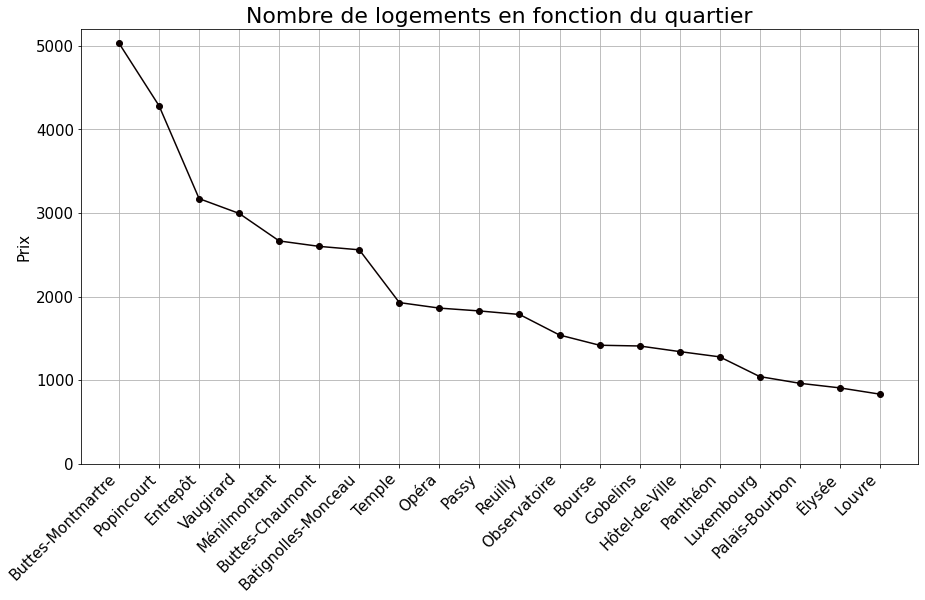

In [14]:
df_temp = df_row.copy()
df_temp = df_temp.groupby('quartier')['prix'].count()
df_temp = df_temp.sort_values(ascending=False)

curve = CurveClass()
curve.plot(df_temp.index, df_temp, ylabel='Prix', marker='o')
curve.ax.set_xticklabels(df_temp.index, rotation=45, ha='right');
curve.ax.grid()
curve.title("Nombre de logements en fonction du quartier");
curve.ax.set_ylim(0, 5200);

### Par catégorie de logement

Le tableau suivant donne le nombre optimal de chambres, lits et salles de bains pour chacun des quartiers. Les graphes suivants représentent sur une colormap le prix total des logements en fonction de leur quartier (axe verticale) et du nombre de chambres, lits et salles de bain (axe horizontale).

Encore une fois, pour tous les quartiers, le nombre optimal de chambres, lits et salles de bains est de un, à l'exception du Louvre pour lequel les logements rapportant le plus sont celles à deux chambres. Or les logements dans chaque quartier doté d'une seule chambre, lit ou salle de bain sont les plus nombreux.

In [15]:
df_temp2 = pd.DataFrame(index=df_row['quartier'].unique())
for name in ['chambres', 'lits', 'salle_de_bain']:
    
    
    df_temp = df_row[[name, 'quartier', 'prix']].copy()
    df_temp = df_temp.groupby([name, 'quartier']).sum()
    df_temp = df_temp.unstack(name)
    df_temp.columns = df_temp.columns.droplevel(0)
    df_temp = pd.DataFrame(df_temp.idxmax(axis=1), columns=['Nombre optimal de %s' % name])
    df_temp2 = df_temp2.merge(df_temp, left_index=True, right_index=True)
display(df_temp2)

,Nombre optimal de chambres,Nombre optimal de lits,Nombre optimal de salle_de_bain
Observatoire,1.0,1.0,1.0
Hôtel-de-Ville,1.0,1.0,1.0
Opéra,1.0,1.0,1.0
Popincourt,1.0,1.0,1.0
Entrepôt,1.0,1.0,1.0
Gobelins,1.0,1.0,1.0
Buttes-Montmartre,1.0,1.0,1.0
Luxembourg,1.0,1.0,1.0
Louvre,1.0,2.0,1.0
Palais-Bourbon,1.0,1.0,1.0


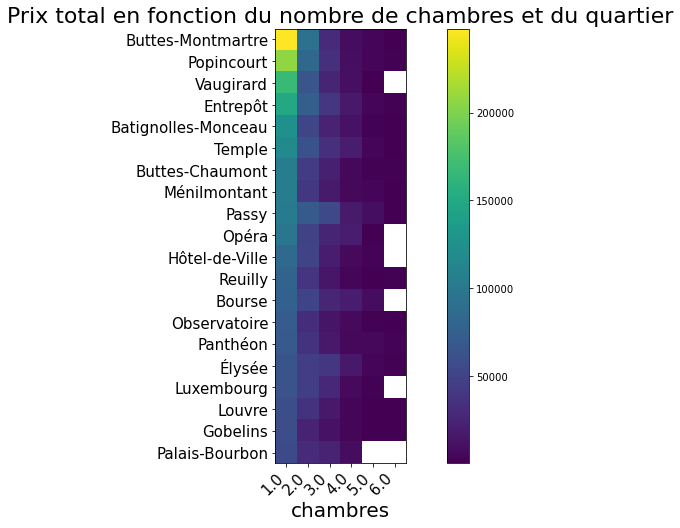

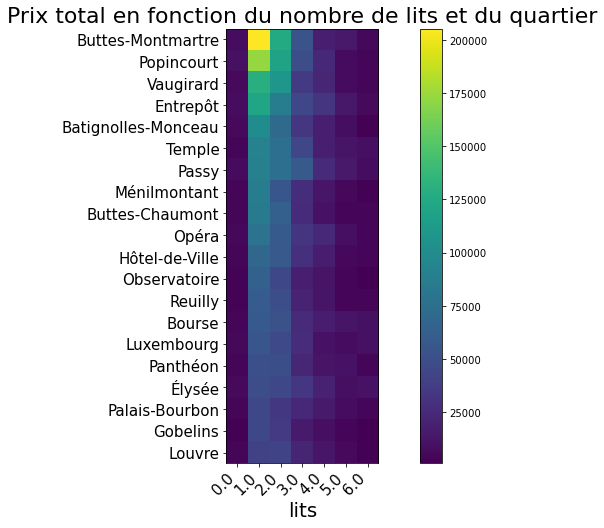

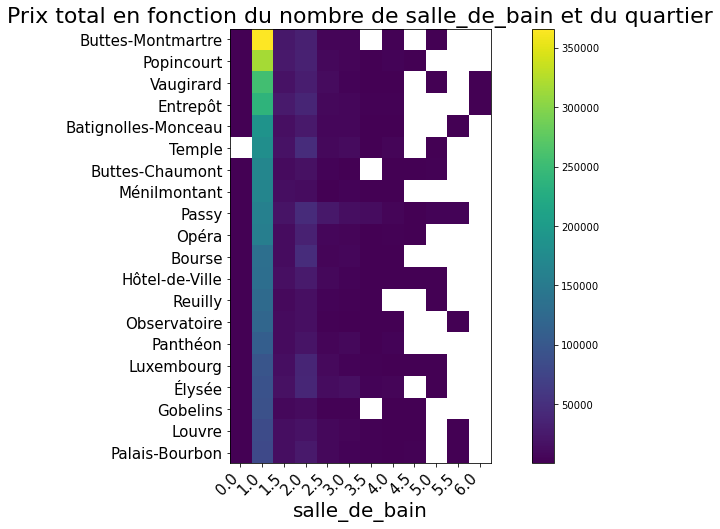

In [16]:
for name in ['chambres', 'lits', 'salle_de_bain']:

    df_temp = df_row[[name, 'quartier', 'prix']].copy()
    df_temp = df_temp[df_temp[name]< 7]
    df_temp = df_temp.groupby([name, 'quartier']).sum()
    df_temp = df_temp.unstack(name)
    df_temp.columns = df_temp.columns.droplevel(0)
    cols = df_temp.max(axis=1).sort_values(ascending=False).index.get_level_values('quartier')

    df_temp = df_temp.loc[cols]

    curve = CurveClass()
    pb.imshow(df_temp)
    curve.ax.set_xlabel(name, fontsize=20)
    
    curve.ax.set_xticks(range(len(df_temp.columns)))
    curve.ax.set_xticklabels(df_temp.columns, rotation=45, ha='right')

    curve.ax.set_yticks(range(len(df_temp.index)))
    curve.ax.set_yticklabels(df_temp.index)

    curve.title('Prix total en fonction du nombre de %s et du quartier' % name)
    pb.colorbar();
    pb.show()

## Croissance

Comme le nombre de locations est important pour déterminer la pertinance d'une catégorie, j'ai représenté la croissance de l'offre de location par quartier, i.e. j'ai calculé le pourcentage de logements récents (moins de deux mois d'activité) et l'ai représenté en fonction du quartier en distinguant grands et petits logements (une chambre ou un lit ou une capacité d'accueil de 2). 

Les petits logements ont une croissance légèrement plus importantes que les grands logements, ce qui augmente leur intérêt. Le pourcentage de nouveaux logements varient de 12 à 27%. Le top trois des quartiers en croissance sont la Butte Montmartre, les Gobelins et Ménilmontant.

Le quartier de la Butte Montmartre renforce donc sa place de quartier le plus intéressant avec sa croissance à presque 30% les deux derniers mois.

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_28253/1499687279.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  curve.ax.set_xticklabels(prop_nouveau_logement.index, rotation=45, ha='right');


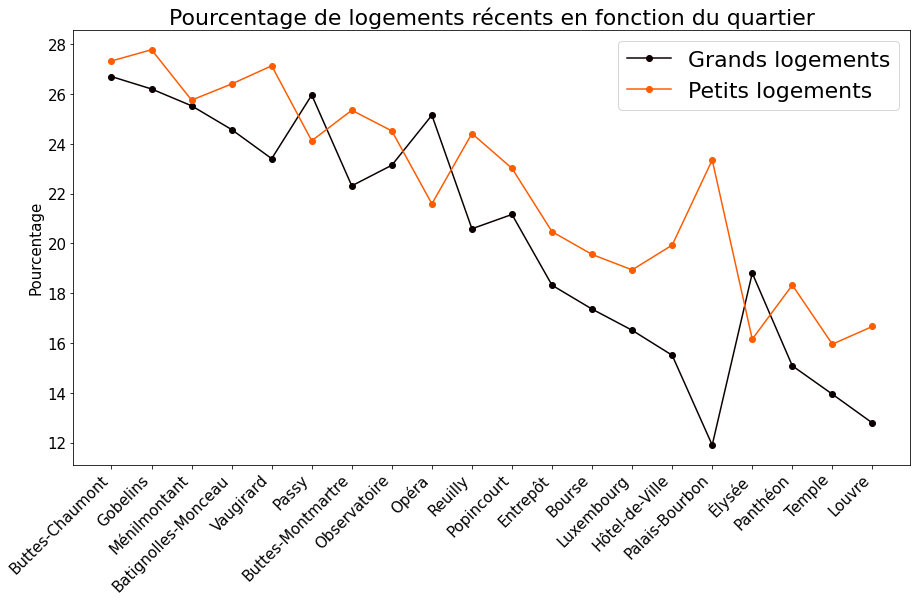

In [17]:
prop_nouveau_logement = pd.DataFrame(index=df_row['quartier'].unique(), columns=['prop_grand', 'prop_petit'])

df_temp2 = df_row[(df_row['lits'] == 1)|(df_row['chambres'] == 1)|(df_row['capacite_accueil'] == 2)]
df_temp3 = df_row[~((df_row['lits'] == 1)|(df_row['chambres'] == 1)|(df_row['capacite_accueil'] == 2))]

for quartier in df_row['quartier'].unique():    
    df_temp = df_temp3[df_temp3['quartier'] == quartier].dropna()
    prop_nouveau_logement.loc[quartier, 'prop_grand'] = len(df_temp[df_temp['nb_mois_en_activite'] < 3])/len(df_temp)
    
    df_temp = df_temp2[df_temp2['quartier'] == quartier].dropna()
    prop_nouveau_logement.loc[quartier, 'prop_petit'] = len(df_temp[df_temp['nb_mois_en_activite'] < 3])/len(df_temp)

prop_nouveau_logement = prop_nouveau_logement.loc[
    prop_nouveau_logement.mean(axis=1).sort_values(ascending=False).index]

curve = CurveClass(2)
curve.plot(
    prop_nouveau_logement.index, prop_nouveau_logement['prop_grand']*100, marker='o', 
    ylabel='Pourcentage', label='Grands logements')
curve.plot(
    prop_nouveau_logement.index, prop_nouveau_logement['prop_petit']*100, marker='o', 
    ylabel='Pourcentage', label='Petits logements')
curve.ax.set_xticklabels(prop_nouveau_logement.index, rotation=45, ha='right');
curve.title('Pourcentage de logements récents en fonction du quartier')
curve.legend()

## Conclusion

Le critère le plus important pour la rentablité d'un logement est sa taille. Les propriétés plus petites sont plus nombreuses (ou plus facilement louable) et représentent la majorité du chiffre d'affaires. Les quartiers de la Butte Montmartre, de Paupincourt et de Vaugirard sont particulièrement interessants, car présentant le plus de petits logements en location touristique. De plus, les quartiers de la Butte Montmartre, des Gobelins et de Ménilmontant sont ceux avec le plus de croissance en terme de logement mis en location.

# Modèles

## Préparation de la donnée

### Nettoyage

Dans la partie en Annexe *Analyses et commentaires de chaque caractéristique*, j'explique pourquoi :
* j'écarte les logements avec zéro salle de bains (très peu de logements à enlever);
* j'écarte les logements sans donnée pour le nombre de lits (très peu de logements à enlever);
* j'écarte les caractéristiques du:
  * quartier (strictement équivalent au arrondissement),
  * des notes moyennes (trop de données manquantes) 
  * et du nombre de mois en activité (trop de données manquantes).

Ce nettoyage écarte 8395 logements (soit 20%) et fournit un jeu de données sans vide. Pour étude plus poussée, il serait important de chercher à conserver plus de données en remplissant les données manquantes.

In [18]:
df_data_temp = df_row.copy()

# suppression des logements avec zero salle de bains
df_data_temp = df_data_temp[df_data_temp['salle_de_bain'] != 0]

# suppression des logements avec un nombre de lits manquant
df_data_temp = df_data_temp[df_data_temp['lits'].notna()]

# suppression des logements avec un nombre de chambres manquant
df_data_temp = df_data_temp[df_data_temp['chambres'].notna()]

# suppression des cractéristiques quartier, note_moyenne et nb_mois_en_activite
df_data_temp = df_data_temp.drop(columns=['quartier', 'note_moyenne', 'nb_mois_en_activite'])
df_data_temp = df_data_temp.reset_index(drop=True)
df_data_temp

,type_propriete,arrondissement,capacite_accueil,salle_de_bain,chambres,lits,prix,nb_commentaires
0,Complète,75004,4,1.0,2.0,2.0,90.0,272
1,Complète,75009,2,1.0,1.0,1.0,130.0,6
2,Complète,75011,2,1.0,1.0,1.0,75.0,26
3,Chambre privée,75010,6,1.0,1.0,3.0,170.0,149
4,Complète,75013,3,1.0,1.0,1.0,110.0,85
...,...,...,...,...,...,...,...,...
33038,Complète,75002,4,2.0,2.0,2.0,101.0,0
33039,Complète,75002,4,2.0,2.0,2.0,101.0,0
33040,Complète,75002,4,2.0,2.0,2.0,118.0,0
33041,Complète,75009,4,1.0,2.0,2.0,192.0,0


In [19]:
print(
    'Nombre de logements écartés par le nettoyage: %i soit %i pourcents des données' % 
    (len(df_row)-len(df_data_temp), int((len(df_row)-len(df_data_temp))/len(df_row)*100)))
print()
print('Nombre de données vides')
df_data_temp.isna().sum()

Nombre de logements écartés par le nettoyage: 8395 soit 20 pourcents des données

Nombre de données vides


type_propriete      0
arrondissement      0
capacite_accueil    0
salle_de_bain       0
chambres            0
lits                0
prix                0
nb_commentaires     0
dtype: int64

### Liste des noms des caractéristiques

In [20]:
# caractéristique à expliquer
name_to_predict = 'prix'

# liste des caractéristiques catégorielles
cat_feature_names = ['type_propriete', 'arrondissement']

# liste des caractéristiques numériques
num_feature_names = ['capacite_accueil', 'salle_de_bain', 'chambres', 'lits', 'nb_commentaires']

# liste de toutes les caractéristiques
feature_names = cat_feature_names+num_feature_names

### Transformation des données catégorielles en numériques

Numériser une caractéristique catégorielle à $n$ catégories consiste à créer $n-1$ colonnes. La première colonne aura des $1$ sur les lignes pour lesquelles la caractéristique vaut la première valeur et $0$ autre part. La deuxième colonne à des $1$ là où la caractéristique vaut la deuxième valeur et ainsi de suite.

Par exemple, numeriser la caractéristique *type de propriété* donne une seule colonne avec des $1$ pour les logements complets et $0$ pour les chambres privées.

In [21]:
df_data = df_data_temp.copy()

# liste des caractéristiques issues de la numérisation
dummies_features = []

# dictionnaire liant des caractéristiques catégorielles à leurs versions numériques
dummies_name_dict = {}

# numerisation de chaque caractéristiques catégorielles
for name in cat_feature_names:
    
    df_dummies = pd.get_dummies(df_data[name], drop_first=True)
    df_data = df_data.merge(df_dummies, left_index=True, right_index=True)
    
    dummies_features += list(df_dummies.columns.astype(str))
    dummies_name_dict[name] = list(df_dummies.columns.astype(str))

df_data.columns = df_data.columns.astype(str)
    
# Rearrangement des noms de colonnes de df_data pour mettre le prix à la fin
cols = list(df_data.columns)
cols.remove(name_to_predict)
cols.append(name_to_predict)
df_data = df_data[cols]
df_data

,type_propriete,arrondissement,capacite_accueil,salle_de_bain,chambres,lits,nb_commentaires,Complète,75002,75003,...,75012,75013,75014,75015,75016,75017,75018,75019,75020,prix
0,Complète,75004,4,1.0,2.0,2.0,272,1,0,0,...,0,0,0,0,0,0,0,0,0,90.0
1,Complète,75009,2,1.0,1.0,1.0,6,1,0,0,...,0,0,0,0,0,0,0,0,0,130.0
2,Complète,75011,2,1.0,1.0,1.0,26,1,0,0,...,0,0,0,0,0,0,0,0,0,75.0
3,Chambre privée,75010,6,1.0,1.0,3.0,149,0,0,0,...,0,0,0,0,0,0,0,0,0,170.0
4,Complète,75013,3,1.0,1.0,1.0,85,1,0,0,...,0,1,0,0,0,0,0,0,0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33038,Complète,75002,4,2.0,2.0,2.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,101.0
33039,Complète,75002,4,2.0,2.0,2.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,101.0
33040,Complète,75002,4,2.0,2.0,2.0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,118.0
33041,Complète,75009,4,1.0,2.0,2.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,192.0


### Liste des combinaisons possibles de caractéristiques

Pour explorer plus tard, différentes configurationd de caractéristiques pour entrainer les modèles, j'établie la liste de toutes les combinaisons possibles de caractéristiques. Ceci est possible, car il y a peu de caractéristiques.

In [22]:
model_features = num_feature_names+cat_feature_names
model_features_list = []

for L in range(1, len(model_features) + 1):
    for subset in itertools.combinations(model_features, L):
        subset = list(subset)
        if 'arrondissement' in subset:
            subset.remove('arrondissement')
            subset += dummies_name_dict['arrondissement']
        if 'type_propriete' in subset:
            subset.remove('type_propriete')
            subset += ['Complète']
        model_features_list.append(subset)

### Indices pour les jeux de données d'entrainement, de test et de validation

Les bonnes pratiques en machine learning est d'établir trois jeux de données (quand c'est possible):
* un train dataset pour entrainer les modèles,
* un test dataset pour tester la performance des modèles entrainés,
* et un validation dataset pour vérifier à la fin si la performance du modèle sélectionné est bien celle attendue. En effet, à force d'explorer les différents modèles et leur hyperparamètres, on peut se retrouver à ajuster le modèle pour optimiser la performance sur le test dataset. Il est donc important de garder une part du jeu de données de départ que l'on va tester que très peu pour assurer une bonne validation.

Ici je tire alétoirement quel logement appartiendra à chacun des trois jeux de données.

In [23]:
np.random.seed(42)

# le test dataset et le validation dataset correspondent chacun à 15% de données
pc_test = .15

shuffle_index = list(df_data.index)
np.random.shuffle(shuffle_index)

lg = len(shuffle_index)
idx_validation = shuffle_index[:int(lg*pc_test)]
idx_test = shuffle_index[int(lg*pc_test):int(lg*pc_test*2)]
idx_train = shuffle_index[-int(lg*(1-2*pc_test)):]

## Discussion autour des caractéristiques

La caractéristique à expliquer est le **prix**.

Après nettoyage, il y a donc sept caractéristiques explicatives:
* le **type de propriété** (catégorielle)
* l'**arrondissement** (catégorielle)
* **capacité d'accueil**
* nombre de l**its**
* nombre de **chambres**
* nombre de **salles de bains**
* nombre de **commentaires**.


### Correlation entre les caractéristiques numériques

La capacité d'accueil, le nombre de lits et le nombre de chambres sont très corrélés (coefficient de correlation entre de 0.73 et 0.81), ce qui n'est pas étonnant. En effet, on s'attend à avoir 1-2 lits par chambres, des lits de 1-2 places et une capacité d'accueil de 1-2 fois le nombre de lits ou 1-4 fois le nombre de chambres.

Avec plus de temps, il serait pertinent d'effectuer une réduction de dimension pour diminuer les risques liés à cette forte corrélation. Par manque de temps, je vais simplement essayer les différentes combinaisons de caractérisitiques pour entrainer les modèles.

Ces trois caractéristiques ainsi que le nombre de salles de bain sont corrélées à hauteur de 0,31-0,34. Il y a donc de fortes chances que ces critéres soient importants pour prédire le prix d'une location.

En revanche, le nombre de commentaires n'est pas corrélés au prix. Il est donc peu probable que cette caractéristique soit significative pour le prix.

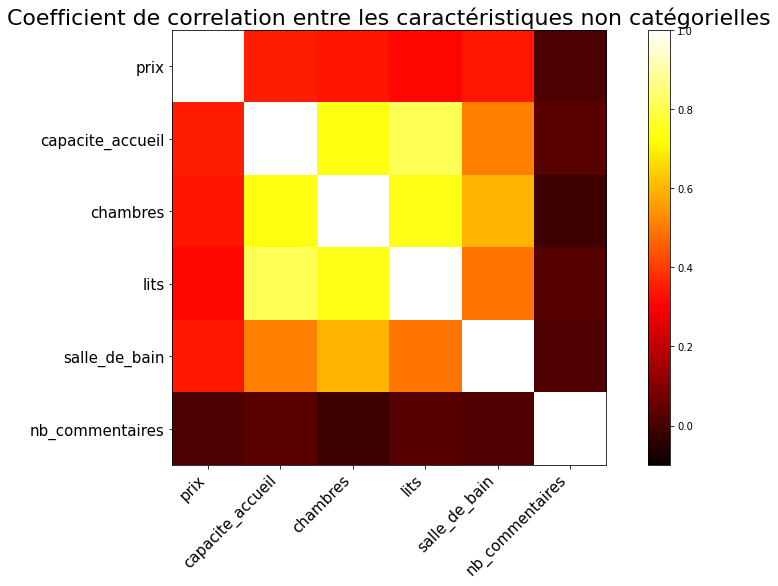

,prix,capacite_accueil,chambres,lits,salle_de_bain,nb_commentaires
prix,1.000000,0.349985,0.336997,0.312878,0.342032,0.010669
capacite_accueil,0.349985,1.000000,0.738468,0.811594,0.514236,0.032879
chambres,0.336997,0.738468,1.000000,0.743257,0.599223,-0.011295
lits,0.312878,0.811594,0.743257,1.000000,0.493982,0.021355
salle_de_bain,0.342032,0.514236,0.599223,0.493982,1.000000,0.014440
nb_commentaires,0.010669,0.032879,-0.011295,0.021355,0.014440,1.000000


In [24]:
features = ['prix', 'capacite_accueil', 'chambres', 'lits', 'salle_de_bain', 'nb_commentaires']
df_corr = df_data[features].corr()

curve = CurveClass()
curve.colormap(df_corr, vmin=-.1, vmax=1)
curve.ax.set_xticklabels(df_corr.columns, rotation=45, ha='right', size=15);
curve.ax.set_yticklabels(df_corr.columns, size=15);
curve.title("Coefficient de correlation entre les caractéristiques non catégorielles")
pb.show()

display(df_corr)

### Correlation entre les caractéristiques catégorielles

La correlation entre le prix et les caractéristiques catégorielles (dans leur version numérisée) est assez faible. La plus grande est avec le type de propriété avec une correlation de 0,1.

/var/folders/vr/b32yycl13ylg3_sjwy88sp980000gn/T/ipykernel_28253/1726091493.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  curve.ax.set_xticklabels(df_corr.index, rotation=45, ha='right', size=15);


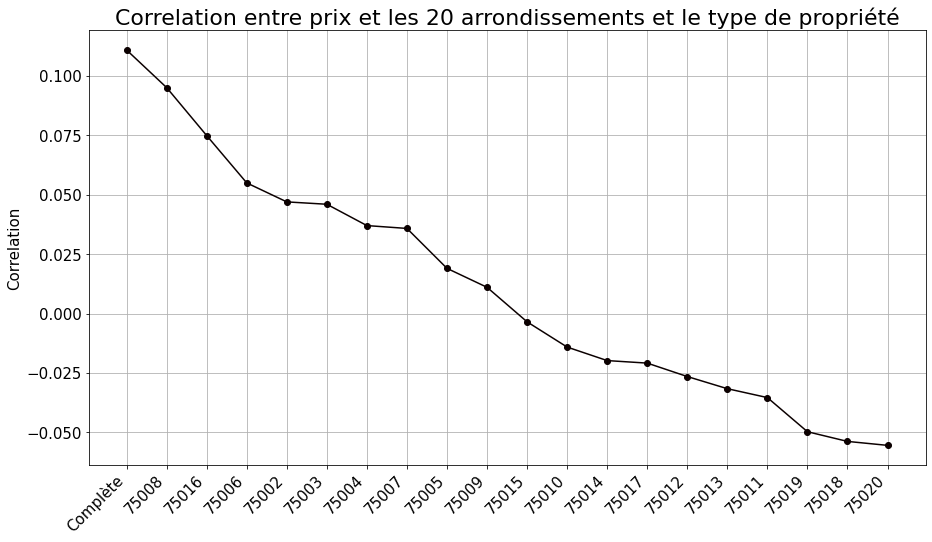

In [25]:
df_sort = df_data[dummies_features+[name_to_predict]].corr()[name_to_predict].sort_values(ascending=False).index

df_corr = df_data[dummies_features+[name_to_predict]][df_sort].corr().iloc[0, 1:]

curve = CurveClass()
curve.plot(df_corr.index, df_corr, marker='o', ylabel='Correlation')
curve.ax.set_xticklabels(df_corr.index, rotation=45, ha='right', size=15);
curve.ax.grid()
curve.title('Correlation entre prix et les 20 arrondissements et le type de propriété')

## Régression linéaire

Dans cette partie, j'essaye une régression linéaire pour expliquer le prix.

Avec les 7 caractéristiques (caractéristiques catégorielles utilisées dans leur version numérique), le modèle de regression linéaire donne une **moyenne de l'erreur absolue d'environ 48** sur les train et test datasets. Ceci n'est pas un très bon résultat. En effet, c'est beaucoup une erreur de 48€ sur des prix de 108€ en moyenne.

J'ai fait une selection des caractéristiques en choisissant le sous ensemble qui maximise le score. J'obtiens à peine mieux avec les cinq caractéristiques : type de propriété, arrondissement, salle de bain, chambre et lits.

In [26]:
model_features = num_feature_names+dummies_features

regression_model = LinearRegressionModelClass(
    df_data=df_data, feature_names=model_features, name_to_predict=name_to_predict, 
    idx_train=idx_train, idx_test=idx_test, idx_validation=idx_validation)

regression_model.predict()

print("distance entre realité et prédiction: train dataset %.2f et test dataset %.2f" % regression_model.score())

distance entre realité et prédiction: train dataset 47.62 et test dataset 48.99


In [27]:
# Comme les calculs sont un peu longs,
# je stocke les scores dans des fichiers LinearRegressionModel_df et LinearRegressionModel_dict
# pour recalculer il suffit de fixes load = False

load = True
linear_regression_exploration = Models.HyperparameterExplorationClass(
    model_class=LinearRegressionModelClass,
    load_root='data/LinearRegressionModel', load=load,
    feature_names_list=model_features_list,
    para_tuple_list=[],
    para_names=[],
    df_data=df_data, name_to_predict=name_to_predict, 
    idx_train=idx_train, idx_test=idx_test, idx_validation=idx_validation)

linear_regression_exploration.exploration()

linear_regression_exploration.print_best_model()

#### Best model ####
LinearRegression
features:  ['salle_de_bain', 'chambres', 'lits', '75002', '75003', '75004', '75005', '75006', '75007', '75008', '75009', '75010', '75011', '75012', '75013', '75014', '75015', '75016', '75017', '75018', '75019', '75020', 'Complète']

## Train score: 47.564
## Test score: 48.581



## Random Forest 

Dans cette partie, je test un algorithme de Random Forest. La nature des données (caractéristiques de valeurs entières présentant une faible variation) correspondent bien à ce genre d'algorithme (arbres de décision, dichotomiques).

J'ai testé quelques configurations: 50 ou 100 arbres de profondeurs de 2 à 4 pour toutes les combinaisons de caractéristiques. Je n'ai pas pu explorer plus d'hyperparamétres au vu du temps imparti et de la puissance du matériel que j'ai à ma disposition.

Malheureusement, les random forests avec ces hyperparamétres ne font pas beaucoup mieux que la regression linéaire avec une erreur absolue moyenne de 47 pour les train et test datasets. Toutefois l'écart entre le score des deux datasets est plus serré, ce qui suposserait un meilleur ajustement (moins de sur-ajustement).

Il faudrait explorer un plus large éventail d'hyperparamètres pour vraiment décider si l'algorithme de random forest n'est pas meilleur que la régression.

In [28]:
n_estimators_list = [50, 100]
max_depth_list = list(range(2, 4))
para_tuple_list = [(n, m) for n in n_estimators_list for m in max_depth_list]

In [29]:
# Comme les calculs sont longs (plus d'une heure sur ma petite machine),
# je stocke les scores dans des fichiers RandomForestModel_df et RandomForestModel_dict
# pour recalculer il suffit de fixes load = False

load = True
random_forest_hyper_para_exploration = Models.HyperparameterExplorationClass(
    model_class=Models.RandomForestClass,
    load_root='data/RandomForestModel', load=load,
    feature_names_list=model_features_list,
    para_tuple_list=para_tuple_list,
    para_names=['n_estimators', 'max_depth'],
    df_data=df_data, name_to_predict=name_to_predict, 
    idx_train=idx_train, idx_test=idx_test, idx_validation=idx_validation)
random_forest_hyper_para_exploration.exploration()

random_forest_hyper_para_exploration.print_best_model()

#### Best model ####
RandomForest
features:  ['capacite_accueil', 'salle_de_bain', 'nb_commentaires', 'Complète']
parameters:  {'n_estimators': 100, 'max_depth': 3}

## Train score: 47.341
## Test score: 47.605



## Validation 

Je calcule tout de même le score de validation pour la regression modèle et le meilleur modèle de random forest, mas sans surprise on retoube sur des scores similaires à ceux calculés sur les train et test dataset.

In [30]:
linear_regression_exploration.print_best_model_validation()
random_forest_hyper_para_exploration.print_best_model_validation()

#### Best model validation####
## LinearRegression
## Validation score: 45.379


#### Best model validation####
## RandomForest
## Validation score: 45.082




## Conclusion

Les résultats des deux modèles testés ne sont pas très satisfaisants en présentant une erreur absolue moyenne de 47€ ce qui est 50% du prix moyen (108€). Ils ne permettent même pas de s'engager sur une reflexion autour d'un éventuel sur ou sous-ajustement.

Il faudrait consacrer plus de temps pour exploiter les randoms forests et d'autre type de modèles.

Toutefois je pense que la distribution des données pose un problème. En effet, la grande majorité des logements a une seule chambre, un lit et une capacité d'accueil de 2. Or ces trois caractéristiques sont les plus significatives pour expliquer le prix et au sein de cette catégorie les loyers varient. Il nous faudrait des caractéristiques en plus de l'arrondissement pour expliquer ces variations. Par exemple, une localisation plus précise, un taux d'activité, une note de l'état général et des services associés, la surface du logement, les équipements...

# Annexe 

## Analyses et commentaires de chaque caractéristique

Les caractéristiques sont assez peu nombreuses pour jeter un oeil à chacune d'entre elles.

### Arrondissement et Quartier

Les caractéristiques *arrondissement* et *quartier* sont rigoureusement équivalentes. En effet, seulement 20 quartiers de Paris sont reportés et chacun correspondent exactement à l'arrondissement dans lequel il se trouve. Nous pouvons donc écarter une des deux caractéristiques. Je choisis de garder les arrondissements.

In [31]:
pd.DataFrame(df_row.groupby(['arrondissement', 'quartier']).count().index)

,0
0,"(75001, Louvre)"
1,"(75002, Bourse)"
2,"(75003, Temple)"
3,"(75004, Hôtel-de-Ville)"
4,"(75005, Panthéon)"
5,"(75006, Luxembourg)"
6,"(75007, Palais-Bourbon)"
7,"(75008, Élysée)"
8,"(75009, Opéra)"
9,"(75010, Entrepôt)"


Il n'y a pas de donnnées manquantes.

In [32]:
df_row['arrondissement'].isna().any()

False

Chaque arrondissement a au moins 900 données, ce qui est une représentation satisfaisante. Les arrondissements les plus représentés sont le 18ème, le 11ème, le 10ème et le 15ème.

La figure suivante représente le nombre de logements par arrondissement.

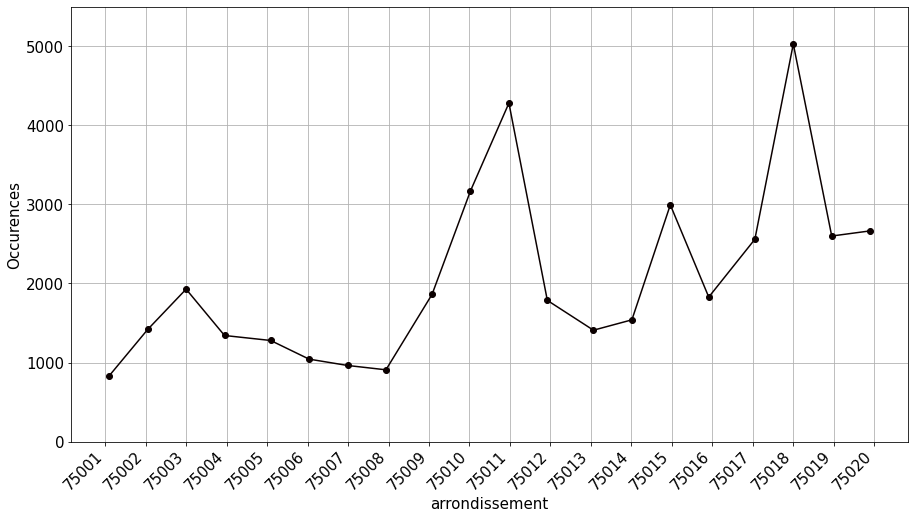

In [33]:
name = 'arrondissement'
vals = list(df_row[name])

curve = CurveClass()
curve.hist(vals, bins=100, xlabel=name, ylabel='Occurences', marker='o')
curve.ax.set_xticks(range(75001, 75021))
curve.ax.set_xticklabels(range(75001, 75021), rotation=45, ha='right')
curve.ax.set_ylim(0, 5500)
curve.ax.grid()

### Type de propriété

Il existe deux types de propriétés *chambre privée* et *compléte*. Dix fois plus de propriétés complétes sont louées que de chambres privées, mais il y a assez de chambres privées pour faire des statistiques. Il n'y a pas de donnée vide.

In [34]:
df_row.groupby('type_propriete').count().loc[:, 'prix':'prix'].rename({'prix': 'Nombre'})

,prix
type_propriete,
Chambre privée,3954
Complète,37484


In [35]:
df_row['arrondissement'].isna().any()

False

### Nombre de chambres

Plus de la moitié des logements ont une chambre. La majorité des autres logements posséde entre 2 et 3 chambres.

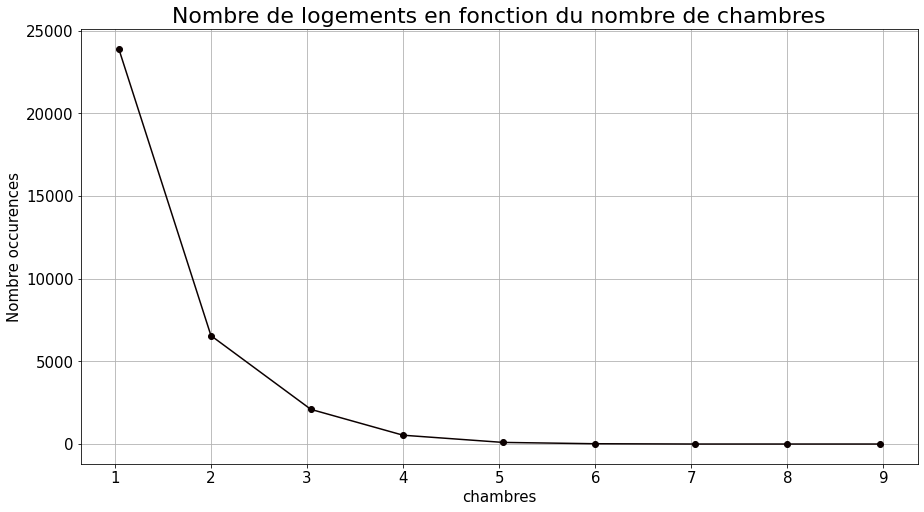

In [36]:
name = 'chambres'
vals = list(df_row[name].dropna())

curve = CurveClass()
curve.hist(vals, bins=100, xlabel=name, ylabel='Nombre occurences', marker='o')
curve.ax.set_xticks(range(1, 10))
curve.ax.grid()
curve.title("Nombre de logements en fonction du nombre de chambres")

Près de 1/5 des données est manquant.

L'information du nombre de chambres est très corrélés au nombre de lit ou à la capacité d'accueil (coefficients de correlation de 0,74) . En effet, dans la majorité des logements, il doit y avoir un à deux lit par chambre et une chambre doit pouvoir abriter entre 2 et 4 personnes. Ainsi ne pas tenir compte du nombre de chambres dans la construction de modèle est envisageable.

Toutefois le nombre de chambre couplé à la capacité d'accueil ou au nombre de lits est un indicateur de *promiscuité* qui peut influencer l'attractivité d'un logement. Par exemple, deux couples en voyage vont préférer deux chambres séparées. Il est donc dommage d'écarter le nombre de chambres.

J'ai donc décidé d'écarter les logements sans donnée pour le nombre de chambres. Ce qui laissera environ 33000 logements ce qui devrait suffire pour cette étude préliminaire d'une journée. A terme, il serait interessant de réfléchir à comment intégrer les logements sans données sur les chambres.

In [37]:
print("Correlation entre le nombre de chambre avec le nombre de lits et la capacité d'accueil")
pd.DataFrame(df_row[['chambres', 'lits', 'capacite_accueil']].corr().loc[['lits', 'capacite_accueil'], 'chambres'])

Correlation entre le nombre de chambre avec le nombre de lits et la capacité d'accueil


,chambres
lits,0.743217
capacite_accueil,0.737657


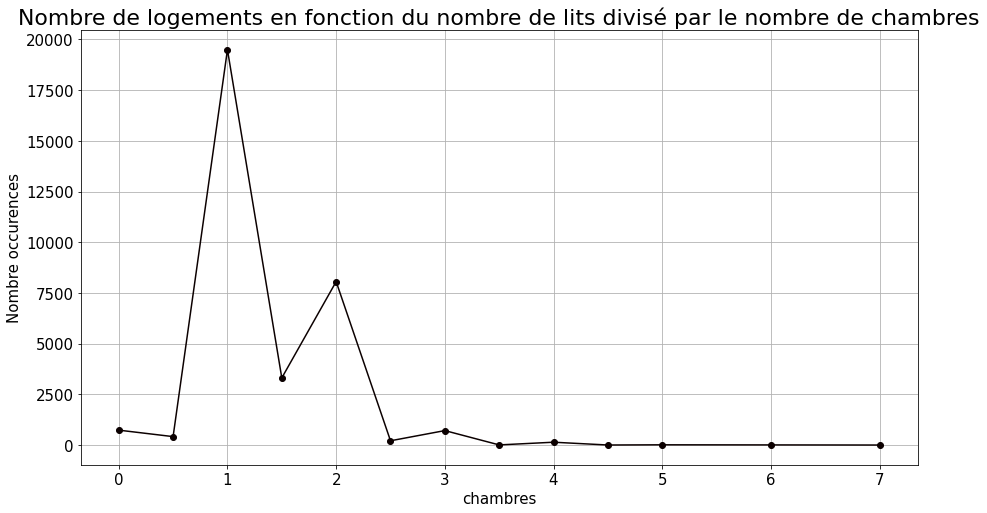

In [38]:
vals = list((df_row['lits']/df_row['chambres']).dropna())

curve = CurveClass()
curve.hist(vals, bins=np.arange(-.25, 8, .5), xlabel=name, ylabel='Nombre occurences', marker='o')
curve.ax.grid()
curve.title("Nombre de logements en fonction du nombre de lits divisé par le nombre de chambres")

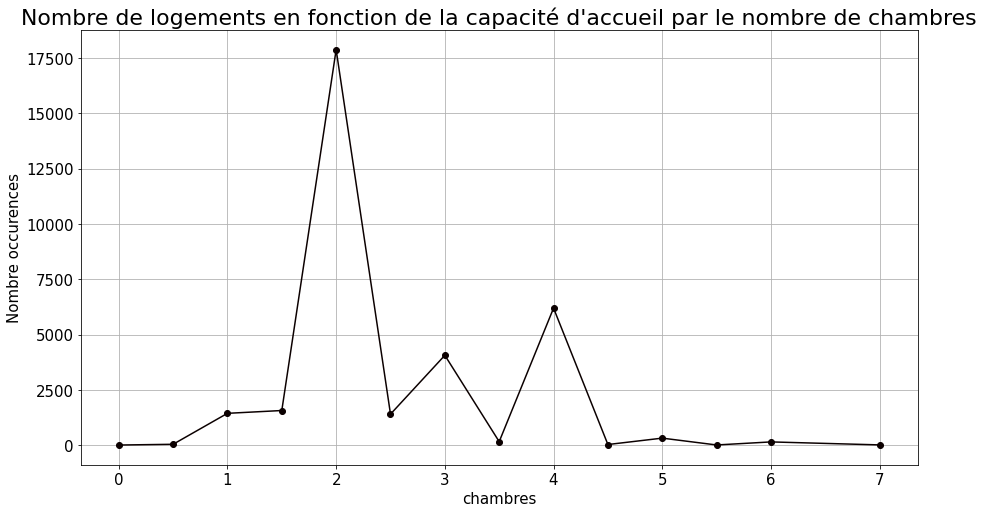

In [39]:
vals = list((df_row['capacite_accueil']/df_row['chambres']).dropna())

curve = CurveClass()
curve.hist(vals, bins=np.arange(-.25, 8, .5), xlabel=name, ylabel='Nombre occurences', marker='o')
curve.ax.grid()
curve.title("Nombre de logements en fonction de la capacité d'accueil par le nombre de chambres")

### Capacité d'accueil

Presque la moitié des logements n'accueille que deux personnes.

Dans la distribution des données en fonction de la capacité, on peut remarquer trois maximaux locaux à 2, 4 et 6 correspondants probablement à 1, 2 et 3 lits doubles. Il doit exister une forte relation linéaire entre la capacité et le nombre de lit: $accueil\approx 2\times lits$. J'irai même plus loin en disant que la capacité d'accueil doit être compris entre le nombre de lits et le nombre de lits multiplié par deux (des lits qui ne peuvent accueillir personne ou plus de deux personnes n'existent pas ou peu). J'écarte donc les logements qui ne respectent pas les relations d'ordre $lits \le capacite\_accueil \le 2\times lits$, ce qui représentent 4888 logements.

La capacité d'acceuil varie de 1 à 16. Mais très peu de logements peuvent acceuillir plus de 6 personnes.

Il n'y a pas de données manquantes.

In [40]:
len(df_row[(df_row['capacite_accueil']<df_row['lits']) |(df_row['capacite_accueil']>2*df_row['lits'])])

4888

In [41]:
df_row['capacite_accueil'].isna().any()

False

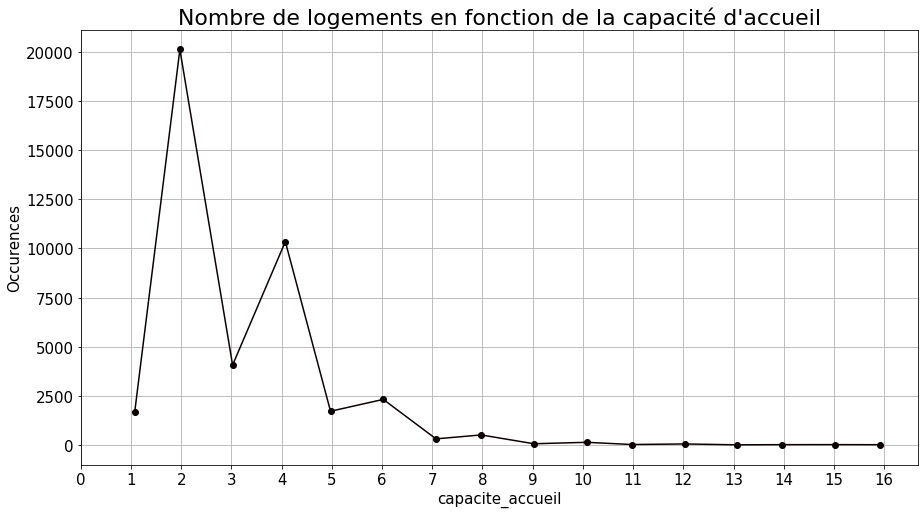

In [42]:
name = 'capacite_accueil'
vals = list(df_row[name])

curve = CurveClass()
curve.hist(vals, bins=100, xlabel=name, ylabel='Occurences', marker='o')
curve.ax.set_xticks(range(0, 17))
curve.ax.grid()
curve.title("Nombre de logements en fonction de la capacité d'accueil")

### Nombre de salles de bain

Le nombre de salles de bain peut aller jusqu'à 6 et certaines données en quantité non négligeables ne sont pas des nombres entiers. J'en conclus que cela doit correspondre à des points d'eau (ex. vasque dans une chambre).

Les 7/8 des logements possédent qu'une seule salle de bain et la majorité du reste posséde 1,5-2 salle de bains. Les logements à plus de deux salle de bains sont donc rares. Il est à noter que 110 logements sont décrits comme exempt de salle de bain, dont 80 d'entre eux sont complets. Je trouve cela étrange. Il est donc possible que ce soit des données incorrectes. Celles-ci étant peu nombreuses, j'ai décidé de les écarter.

In [43]:
df_row[df_row['salle_de_bain'] == 0].groupby('type_propriete').count().loc[:, 'quartier':'quartier'].rename(columns={'quartier': 'Nombre de logements sans salle de bain'})

,Nombre de logements sans salle de bain
type_propriete,
Chambre privée,28
Complète,82


Il n'y a pas de données vides.

In [44]:
df_row['salle_de_bain'].isna().any()

False

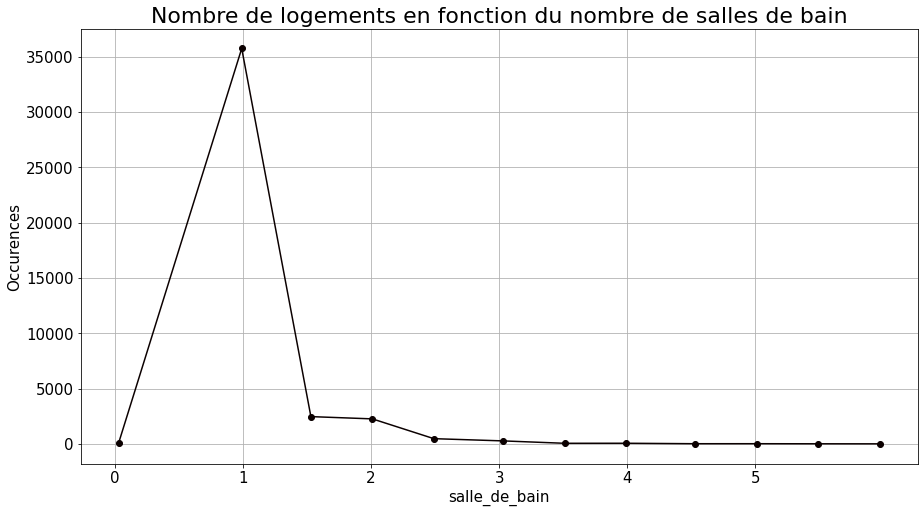

In [45]:
name = 'salle_de_bain'
vals = list(df_row[name])

curve = CurveClass()
curve.hist(vals, bins=100, xlabel=name, ylabel='Occurences', marker='o')
curve.ax.set_xticks(range(0, 6))
curve.ax.grid()
curve.title("Nombre de logements en fonction du nombre de salles de bain")

### Nombre de lits

Le nombre de salles de bain peut aller jusqu'à 16, mais la plupart des logements ont moins de 4 lits.

Il est à noter que plus de 1000 logements sont décrits comme exempt de lit. Il est possible que ce soit des canapés lit déclarés comme n'étant pas des vrais lits. On pourrait donc les compter comme des lits et fixé à 1 le nombre de lits des logements décrits sans lit.

En toute logique, il devrait y avoir au moins un lit par chambre: $lits\ge chambres$. Or plus de 12000 logements ont plus de chambres que de lits. Il est donc problables que chambres signifie plutôt piéces.

Les logements sans données sur le nombre de lits sont peu nombreux donc simplement écartés.

In [46]:
df_row[df_row['lits'] == 0].groupby('chambres').count().loc[:, 'quartier':'quartier'].rename(columns={'quartier': 'Nombre de logements sans lit'})

,Nombre de logements sans lit
chambres,
1.0,615
2.0,90
3.0,22
4.0,6
5.0,1


In [47]:
df_row[df_row['chambres']<df_row['lits']]

,type_propriete,quartier,arrondissement,capacite_accueil,salle_de_bain,chambres,lits,prix,nb_commentaires,note_moyenne,nb_mois_en_activite
4,Chambre privée,Entrepôt,75010,6,1.0,1.0,3.0,170.0,149,92.0,66.0
8,Complète,Gobelins,75013,5,1.0,1.0,3.0,70.0,30,90.0,68.0
10,Chambre privée,Luxembourg,75006,4,1.5,1.0,2.0,66.0,88,98.0,131.0
16,Complète,Palais-Bourbon,75007,4,1.0,1.0,2.0,134.0,219,92.0,114.0
17,Complète,Reuilly,75012,5,1.0,2.0,3.0,197.0,101,96.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...
41415,Complète,Buttes-Montmartre,75018,3,1.0,1.0,2.0,33.0,0,NaN,NaN
41418,Complète,Entrepôt,75010,6,1.0,2.0,3.0,359.0,0,NaN,NaN
41422,Complète,Vaugirard,75015,4,1.0,1.0,2.0,80.0,0,NaN,NaN
41430,Complète,Temple,75003,6,2.0,2.0,3.0,174.0,0,NaN,NaN


In [48]:
df_row['lits'].isna().sum()

145

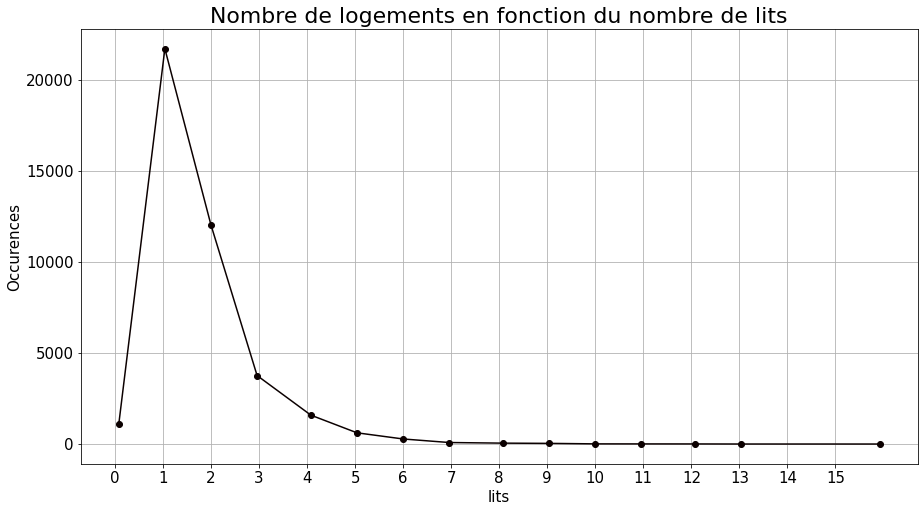

In [49]:
name = 'lits'
vals = list(df_row[name].dropna())

curve = CurveClass()
curve.hist(vals, bins=100, xlabel=name, ylabel='Occurences', marker='o')
curve.ax.set_xticks(range(0, 16))
curve.ax.grid()
curve.title("Nombre de logements en fonction du nombre de lits")

### Nombre de commentaires, note moyenne et nombre de mois en activité

**Nombre de commentaires**
Le nombre de commentaires n'est pas en soi une bonne caractéristique. Des bons ou mauvais commentaires peuvent influencer l'attractivité du logement et donc son prix. Toutefois il peut y avoir beaucoup de commentaires dans les deux cas: soit on s'exprime pour expliquer à quelle point cela a été bien ou on écrit pour prévenir les autres clients de ne pas choisir ce logement.

Il est possible que le nombre de commentaires puisse être un indicateur pour des prix "extrêmes": beaucoup de mauvais commentaires fait chuter le prix et beaucoup de bons commentaires propulsent le prix haut. Toutefois cette hypothèse devient sophistiquée pour le temps imparti à cette étude. Elle mériterait que l'on s'y penche si des modèles simples ne parviennent pas prédire correctement le prix d'un logement.

Un autre argument qui rend le nombre de commentaires non interessants en soi est que cette caractéristique est corrélée au nombre de mois en activité (coefficient de correlation de 0.6). Ce qui est logique: plus longtemps de logement est en location, plus de clients ont pu le commenter. Il faudrait donc plutôt utiliser le nombre de commentaires par mois d'activité.

**Note moyenne**
A la lumière des remarques précédentes, la note moyenne pourrait donc être très interessante. Toutefois près d'un quart des notes moyennes sont manquantes. Il est possible de les remplacer par la valeur médiane de toutes les notes, mais cette solution n'est pas toute à fait suffisante au vu du nombre de données manquantes. A cause du temps qui m'est imparti, j'ai décidé d'écarter cette catactéristique de ma recherche de modèle.

**Nombre de mois d'activité**
La donnée du taux d'activité d'un logement est important pour optimiser ses gains. En effet, un logement avec un lit double aura plus de chance d'être souvent loué qu'un appartement pour huit personnes.

Toutefois ce n'est pas ce que fournit le nombre de mois d'activité. Il indique depuis combien de temps le logement est disponible sur la plateforme. Il n'est pas étonnant que cette donnée soit liée au nombre de commentaires. 

Son interet pour prédire le prix d'un logement n'est pas évident. Il est possible qu'au moment de sa mise à disposition son prix soit sur-évalué et donc diminue son taux de location. Avec le temps le propriétaire peut ajuster son prix et améliorer son rendement et vice vera en cas de sous-évaluation. Ainsi le nombre de mois d'activité pourrait être un indicateur de la pertinence du prix d'un logement. Il serait donc interessant de predire le prix d'un logement en utilisant seulement les données avec assez d'ancienneté.

Toutefois il manque 1/5 du nombre de mois d'activité. Pour les mêmes raisons que pour les notes moyennes, j'ai décidé de ne pas utiliser cette caractéristique.


In [50]:
print('nombre de notes moyennes manquantes:', df_row['note_moyenne'].isna().sum())
print("nombre de mois d'activité manquante:", df_row['nb_mois_en_activite'].isna().sum())

nombre de notes moyennes manquantes: 9025
nombre de mois d'activité manquante: 8271


In [51]:
print("Correlation entre le nombre de commentaires et le nombre de mois en activité: ",
     round(df_row[['nb_commentaires', 'nb_mois_en_activite']].corr().iloc[0, 1], 3))


Correlation entre le nombre de commentaires et le nombre de mois en activité:  0.603


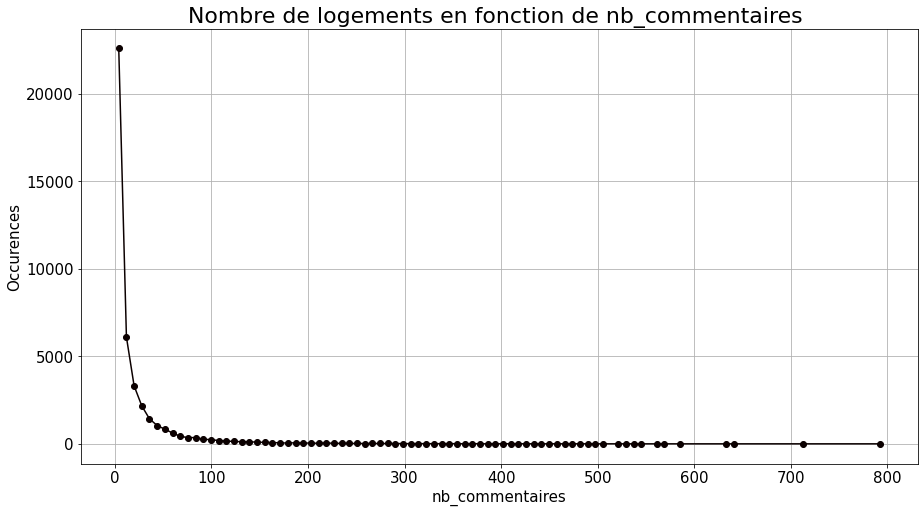

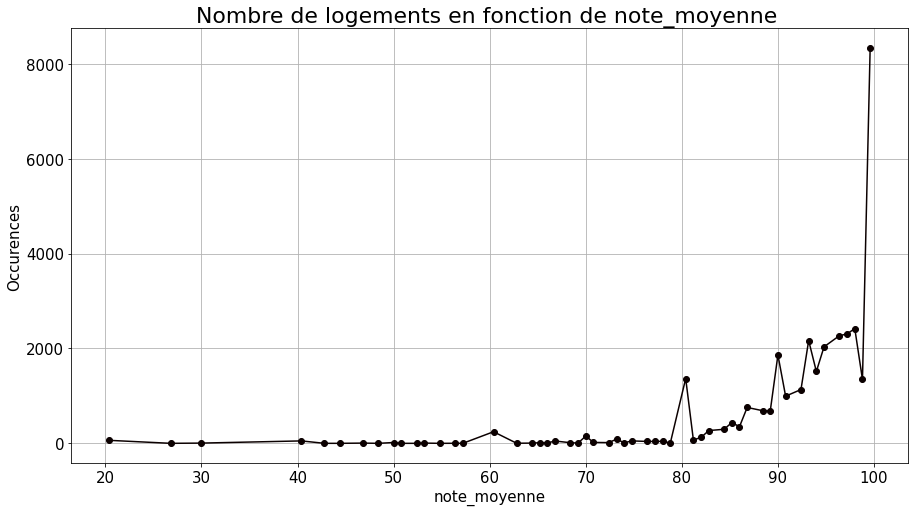

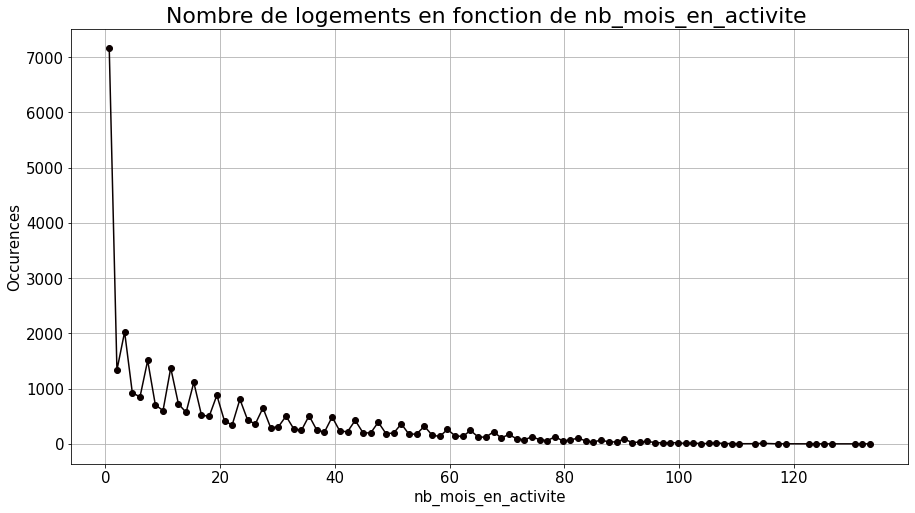

In [52]:
for name in ['nb_commentaires', 'note_moyenne', 'nb_mois_en_activite']:
    vals = list(df_row[name].dropna())

    curve = CurveClass()
    curve.hist(vals, bins=100, xlabel=name, ylabel='Occurences', marker='o')
    #curve.ax.set_xticks(range(0, 16))
    curve.ax.grid()
    curve.title("Nombre de logements en fonction de %s " % name)